<h1> Random Forest on Scan 11 </h1>

In [93]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import pandas as pd

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [94]:
# Loading in Image 

img_nifti = nib.load("cdmri11_r.nii")

img =img_nifti.dataobj[:,:,:,:]


In [95]:
# Loading in Mask

mask_nifti = nib.load("cdmri11_mask.nii")

mask = mask_nifti.dataobj[:,:,:]

In [96]:
# Final Image 

arr = img.copy()
for i in range (0,1344):
    arr[:,:,:,i] = mask*img[:,:,:,i]; 

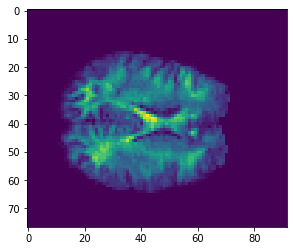

In [97]:
plt.imshow(arr[:,:,33,33])

In [98]:
# Importing Parameters

p = np.loadtxt('parameters_new.txt')
p.shape

(1344, 6)

In [99]:
param = np.zeros([1344,6])
param = p.copy()
# Switching first two columns as:
# [x y z] --> [y -x z] (scanner to measurement coordinate system)
param[:, 0], param[:, 1] = p[:, 1], p[:, 0].copy()
param[:,1] = -param[:,1]

# had to check, but is correct
# np.savetxt('changed_param.txt', param, fmt='%1.5f')

param

array([[-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.0000e+01,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  1.2364e+03,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.4727e+03,
         8.0000e+01],
       ...,
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  2.2961e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  3.5325e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  7.3227e+03,
         1.3000e+02]])

In [100]:
b = p[:,3]
TI = p[:,4]
TE = p[:,5]

# Filter based on TI fulfilling condition
vals = TI>TI_limit
indices = np.where(TI>TI_limit)
b0idx = np.where(b==0)   

TI=TI[indices]
TE=TE[indices]
param=param[indices]
b=b[indices]
res_selected = arr[:,:,:,indices]

In [101]:
# From Stackoverflow: https://stackoverflow.com/questions/45637778/how-to-find-intersect-indexes-and-values-in-python
# Function takes unique elements from each array, puts them together, and concatenates
import numpy as np
def intersect_mtlb(a, b):
    a1, ia = np.unique(a, return_index=True)
    b1, ib = np.unique(b, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]

c, idx_b0, ib = intersect_mtlb(indices, b0idx )

s0init = np.mean(arr[:,:,:,idx_b0], axis = 3) 

# Initial Values and Objective Function
b=b/1000
x0 = [300, 2, 1000, 100, 1, 1, 1, 0, 0, 0]

<h3> Selecting for Mainly Diffusion Effects </h3> 

In [127]:
# Extract indices

low_TE_ind = np.where(TE<100)
high_TI_ind = np.where(TI>4600) # First trial was 1500
diff_ind = np.intersect1d(high_TI_ind, low_TE_ind, assume_unique=True)

In [128]:
diff_ind.shape

(32,)

In [129]:
# Select Relevant Data
res_selected = res_selected[:,:,:,:,diff_ind]
b = b[diff_ind]
TI = TI[diff_ind]
TE = TE[diff_ind]
param = param[diff_ind,:]

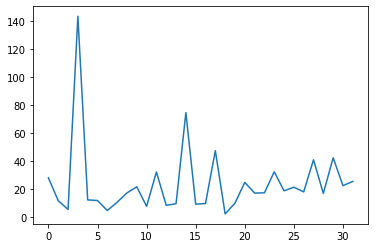

In [130]:
plt.plot(res_selected[40,40,33,0,:])

<h2> Creating Training and Test Sets </h2> 

In [131]:
# Importing Features

CSF_im = nib.load("CSF_100_S11.nii")
WM_im = nib.load("WM_100_S11.nii")
GM_im = nib.load("GM_100_S11.nii")


In [132]:
Label_CSF = CSF_im.dataobj[:,:,:]
Label_WM = WM_im.dataobj[:,:,:]
Label_GM = GM_im.dataobj[:,:,:]

In [133]:
param.shape

(32, 6)

In [134]:
p.shape

(1344, 6)

In [135]:
arr.shape

(77, 92, 56, 1344)

In [136]:
res_selected= np.squeeze(res_selected)
res_selected.shape

(77, 92, 56, 32)

In [137]:
# Data Size
CSF_num = np.asarray(np.nonzero(Label_CSF)).shape[1]
WM_num = np.asarray(np.nonzero(Label_WM)).shape[1]
GM_num = np.asarray(np.nonzero(Label_GM)).shape[1]
rows = CSF_num + WM_num +GM_num

In [138]:
rows

497

In [139]:
# Setting Key and Creating Labelled Data

## Key ---------------------------------------
# 1 - WM                                     \
# 2 - GM                                     \
# 3 - CSF                                    \
# --------------------------------------------

# Creating Labelled Data
labelled_data_org_pos = np.zeros([rows,4])
   
 # WM values
coords_WM = np.transpose(np.asarray((np.nonzero(Label_WM))))
label_WM = np.c_[coords_WM, np.transpose(np.ones([1,WM_num]))]
labelled_data_org_pos[0:WM_num,:] = label_WM

# GM values
coords_GM = np.transpose(np.asarray((np.nonzero(Label_GM))))
label_GM = np.c_[coords_GM, np.transpose(2*np.ones([1,GM_num]))]
labelled_data_org_pos[WM_num:(WM_num+GM_num),:] = label_GM
    
# CSF values
coords_CSF = np.transpose(np.asarray((np.nonzero(Label_CSF))))
label_CSF = np.concatenate((coords_CSF, np.transpose(3*np.ones([1,CSF_num]))),axis = 1 )
labelled_data_org_pos[(WM_num+GM_num):(GM_num+CSF_num+WM_num),:] = label_CSF

labelled_data_org_pos
labelled_data_org_pos = labelled_data_org_pos.astype(int)

In [140]:
total_num_labels = labelled_data_org_pos.shape[0]

In [141]:
# Full Labelled Data
col = param.shape[0]+1 ]
param_num = param.shape[0]
full_label_data = np.zeros([total_num_labels,col])
full_label_data[:,-1] = labelled_data_org_pos[:,-1]
unlabelled_data = res_selected.copy()
for i in range (0,total_num_labels):
    full_label_data[i,:-1] = res_selected[labelled_data_org_pos[i,0], labelled_data_org_pos[i,1], labelled_data_org_pos[i,2],:]
    # unlabelled_data[labelled_data_org_pos[i,0], labelled_data_org_pos[i,1], labelled_data_org_pos[i,2],:] = np.nan
    # help, is this necessary? 

In [142]:
res_selected.shape

(77, 92, 56, 32)

In [143]:
# Creating Train and Test Sets

X_train = full_label_data[:,:-1]
y_train = full_label_data[:,-1]
X_test = np.reshape(unlabelled_data, (396704,param_num)) # checked that keeps structure by reshaping back and comparing to initial

In [144]:
# Performing Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(max_depth=5, n_estimators=50, random_state=0)
clf.fit(X_train,y_train)

# Grid Search
from sklearn.model_selection import GridSearchCV

# Specify parameters and parameter distributions

param_dist = {"max_depth": [3, 5, 10, 20, 50],
              "max_features": np.linspace(10,param_num,5).astype(int),
              "n_estimators": [10,20,50,100]
              }

# GridSearchCV Instance
grid = GridSearchCV(estimator=clf, param_grid=param_dist,cv=5,iid=False)
# Perform Grid Search  
grid.fit(X_train, y_train)

# summarize the results of the grid search
print('Best classification score achieved using grid search:', grid.best_score_)
print('The parameters resulting in the best score are: depth {},max_f {} and n_estimators {} '\
      .format(grid.best_estimator_.max_depth,grid.best_estimator_.max_features,\
              grid.best_estimator_.n_estimators))

# Create RF model using optimised parameters
clf=RandomForestClassifier(max_depth=grid.best_estimator_.max_depth,max_features=\
                            grid.best_estimator_.max_features,\
                            n_estimators=grid.best_estimator_.n_estimators,
                            random_state=42)
clf.fit(X_train,y_train)

# Predict Labels
y_predicted = clf.predict(X_test)
y_predicted = np.reshape(y_predicted, (77, 92, 56))

Best classification score achieved using grid search: 0.975917591759176
The parameters resulting in the best score are: depth 10,max_f 10 and n_estimators 50 


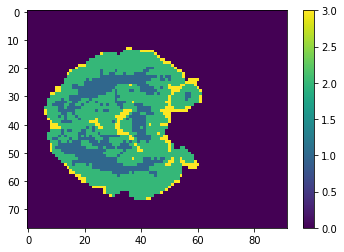

In [145]:
# Displaying Result
result = y_predicted*mask
plt.imshow(result[:,:,20])
plt.colorbar()

In [146]:
# Probabilistic Results
predicted_probs = clf.predict_proba(X_test)
predicted_probs = np.reshape(predicted_probs, (77, 92, 56, 3))

# Creating pixel values as a weighted sum of colors
predicted_probs_color = predicted_probs * 255 

Text(0.5, 1.0, 'Probabilistic Map 100p')

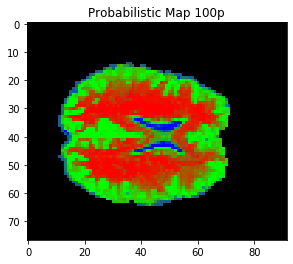

In [147]:
# Displaying Result

# 1 WM Red
# 2 GM Green
# 3 CSF Blue

prob_result = predicted_probs_color;
prob_result[:,:,:,0] = prob_result[:,:,:,0]*mask
prob_result[:,:,:,1] = prob_result[:,:,:,1]*mask
prob_result[:,:,:,2] = prob_result[:,:,:,2]*mask


plt.imshow(prob_result[:,:,33,:].astype('uint8'))
plt.title('Probabilistic Map 100p')